In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import seaborn as sns
from tqdm import tqdm
from scipy.ndimage import center_of_mass

In [2]:
cases_admiss = {}
admiss_occup = {}

In [3]:
# download api data
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=hospitalCases&metric=newAdmissions&metric=newCasesBySpecimenDate&format=json"#&release=2021-07-06"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df = pd.DataFrame(response['body'])
df['dateTime'] = pd.to_datetime(df['date'])
df.sort_values(by=['dateTime'], inplace=True)
df.dropna(inplace=True)

x_dateTimes = sorted(list(set(df.dateTime.to_list())))
top_date = x_dateTimes[-1].strftime("%Y-%m-%d")
print(top_date)

2021-08-25


In [4]:
waves = [
    {"start":"2020-08-01", "end":top_date},    
    {},
    {"start":"2020-11-01", "end":"2021-03-01"},    
    {"start":"2021-03-01", "end":top_date},
    {"start":"2021-01-01", "end":top_date}
]

wave = 2
start_date = waves[wave]["start"]
end_date = waves[wave]["end"]

_df = df[(df.dateTime >= start_date) & (df.dateTime <= end_date)]
cases_stream = np.array(_df.newCasesBySpecimenDate.to_list(), dtype=int)
admissions_stream = np.array(_df.newAdmissions.to_list(), dtype=int)
occupancy_stream = np.array(_df.hospitalCases.to_list(), dtype=int)
#occupancy_stream -= occupancy_stream[0]

def N_avg(a, N=7):
    # weekly avg into the past
    b = np.zeros(len(a)-N)
    for i in range(N,len(a),1):
        b[i-N] = np.mean(a[i-N:i])
    return b

#cases_stream = N_avg(cases_stream)
#admissions_stream = N_avg(admissions_stream)
#occupancy_stream = N_avg(occupancy_stream)

print(cases_stream)
print(admissions_stream)
print(occupancy_stream)
print(len(occupancy_stream))

[13367 27928 22306 20695 20876 20829 16616 17964 28093 24465 24646 21951
 21653 16037 14211 23723 20322 18210 15500 14679 10613 10036 16208 14029
 13928 12279 12265  9206  8903 15029 13515 13465 12527 12885 10143 10871
 17394 16670 17461 18546 19861 16029 18129 29512 29095 30125 29593 31833
 21733 28933 42599 40902 37610 28694 12674 36708 42433 40038 72505 62887
 46685 28221 54166 49511 69110 58033 51312 46851 42332 35442 32852 51993
 44667 41157 38520 36790 27653 26208 40714 35966 31751 28750 26907 19874
 15454 27110 24437 23231 21840 19679 15000 13707 20112 17656 17405 16153
 13971 10585 10155 13845 12241 11839 11226 10562  7737  7533 12468 10816
 10020  9907  8882  6890  6799  9856  8141  7291  6610  5665  4103  3952
  5888]
[1280 1331 1246 1382 1346 1182 1319 1488 1551 1592 1711 1666 1433 1388
 1467 1560 1491 1571 1484 1316 1255 1333 1385 1277 1415 1198 1055 1065
 1215 1216 1271 1262 1337 1248 1186 1311 1466 1528 1550 1524 1450 1587
 1581 1746 1730 1796 1873 1672 1812 1976 2115 220

In [5]:
def _f(x, in_stream, out_stream):
    # model out_stream as a convolution of in_stream with x
    target_out_stream = out_stream[len(x)-1:]
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def f(xs, in_stream=cases_stream, out_stream=admissions_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _f(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret        

In [6]:
n_dim = 30
n_particles = 1000

x_max = 0.1*np.ones(n_dim)
x_min = -0.01*np.ones(n_dim)
options = {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
bounds = (x_min, x_max)
init_pos = np.array([np.zeros(n_dim) for i in range(n_particles)])

cases_admiss_outputs = []

In [7]:
for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(f, 2000, verbose=True, n_processes=10)
    cases_admiss_outputs.append(pos)
cases_admiss_outputs = np.array(cases_admiss_outputs)

2021-08-28 19:01:34,296 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=144 
2021-08-28 19:01:43,904 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 144.2014467330639, best pos: [ 0.00884741  0.00569618  0.00478651  0.00472551  0.00305919  0.00740918
  0.00704648  0.00609831  0.00076434  0.0052568   0.0059321   0.00081027
  0.00214222 -0.00016944  0.00164466  0.00215008  0.00232614  0.00186686
  0.00049802  0.00010258  0.00116441  0.00051771  0.00138605  0.00257187
  0.00405312  0.00085192  0.00010233  0.00121466  0.00065831  0.00163774]
2021-08-28 19:01:43,914 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=197 
2021-08-28 19:01:53,803 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 196.9925858049371

2021-08-28 19:03:31,034 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=189 
2021-08-28 19:03:40,595 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 189.4304481608745, best pos: [0.00614114 0.00494362 0.00714384 0.00442709 0.00271695 0.00223077
 0.00373429 0.00977904 0.00095662 0.00099324 0.00450964 0.00435814
 0.00259497 0.00310121 0.00142482 0.00106211 0.00301    0.0017321
 0.00127002 0.0022617  0.00351741 0.00148015 0.00100409 0.0018021
 0.00222527 0.00097944 0.00141221 0.00268935 0.00109551 0.00076777]
2021-08-28 19:03:40,604 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=156 
2021-08-28 19:03:50,280 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 156.13216669499488, best pos: [ 0.00978726  0.003

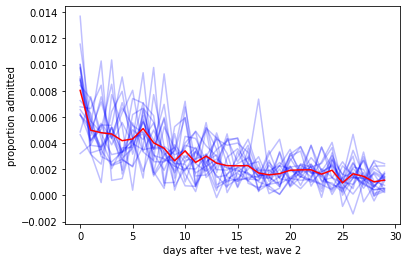

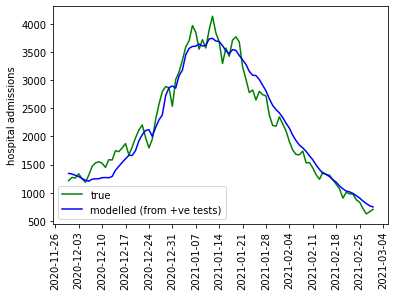

In [8]:
plt.clf()
x = list(range(len(pos)))
for y in cases_admiss_outputs:
    #print(sum(y))
    plt.plot(x, y, color="blue", alpha=0.25)
y_avg_cases_admiss = []
for i in range(len(y)):
    y_avg_cases_admiss.append(np.mean(cases_admiss_outputs[:,i]))
plt.plot(x, y_avg_cases_admiss, color="red", alpha=1)
plt.xlabel("days after +ve test, wave %d" % wave)
plt.ylabel("proportion admitted")
plt.savefig("cases_admiss_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

plt.clf()
true, pred = _f(y_avg_cases_admiss, cases_stream, admissions_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true, color="green", label="true")
plt.plot(x, pred, color="blue", label="modelled (from +ve tests)")
#plt.xlabel("days after start of wave %d" % wave)
plt.ylabel("hospital admissions")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.savefig("cases_admiss_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()


cases_admiss[wave] = y_avg_cases_admiss

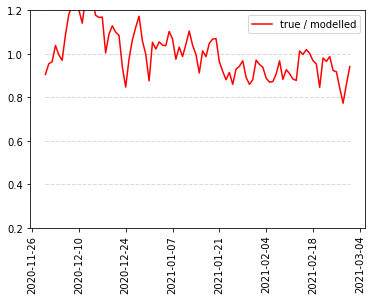

[0.90510983 0.9539659  0.96373433 1.03857439 0.99605911 0.97021932
 1.0884471  1.18200635 1.22539146 1.24039381 1.20278373 1.14136497
 1.25371904 1.2260702  1.24829163 1.17739301 1.16754486 1.16922622
 1.0044009  1.08999954 1.1288295  1.09993012 1.08478372 0.94025138
 0.84696957 0.97594332 1.06412235 1.12200435 1.1729019  1.05975024
 0.9980891  0.8756765  1.05325636 1.02218226 1.05481272 1.04010612
 1.03744474 1.1028324  1.06845654 0.97508445 1.03121644 0.98766907
 1.04356129 1.10489662 1.03941184 0.99786281 0.91206334 1.01352184
 0.98729124 1.04822278 1.06804581 1.06987704 0.96375798 0.91961715
 0.8808423  0.91471172 0.85977094 0.92976561 0.94262123 0.96797458
 0.89185137 0.85975137 0.88123985 0.9711424  0.95123333 0.93851985
 0.88844985 0.86979866 0.87249386 0.90780341 0.96797365 0.88267032
 0.92701981 0.90920188 0.88417707 0.8778709  1.01339005 0.99694135
 1.01953325 1.00223573 0.96847221 0.95341389 0.84591858 0.98095564
 0.96509706 0.9878593  0.92386542 0.91729946 0.84248705 0.7731

In [9]:
plt.clf()
true, pred = _f(cases_admiss[2], cases_stream, admissions_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true/pred, color="red", label="true / modelled")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(14))
plt.ylim(0.2,1.2)
y_locs,_ = plt.yticks()
plt.hlines(y_locs, x[0], x[-1], color="black", linestyles='dashed', alpha=0.15, linewidth=1)
plt.savefig("cases_admiss_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

print((true/pred))

2 0.08517307120126662 (10.266996219292178,)


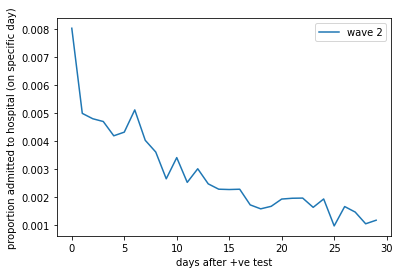

In [10]:
for wave,y_avg_cases_admiss in cases_admiss.items():
    print(wave, np.sum(y_avg_cases_admiss), center_of_mass(np.array(y_avg_cases_admiss)))
          
plt.clf()
x = range(n_dim)
for wave,y_avg_cases_admiss in cases_admiss.items():
    if (wave==4):
        continue
    plt.plot(x, y_avg_cases_admiss, label="wave %d" % wave)
plt.xlabel("days after +ve test")
plt.ylabel("proportion admitted to hospital (on specific day)")
plt.legend()
plt.savefig("cases_admiss_compare.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()
#print(list(zip(x,y_avg_cases_admiss)))

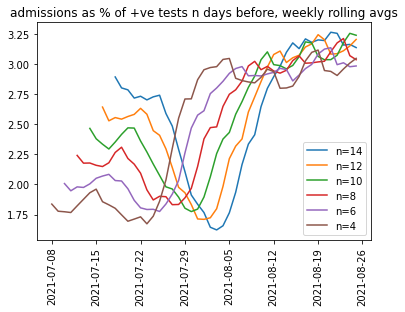

In [11]:
x_dateTimes = df.dateTime.to_list()[-len(x)-30:]

y = {}
admiss_rolling = {}
cases_rolling = {}
for n in [14,12,10,8,6,4]:
    _y1 = []
    _y2 = []
    _y = []
    for dateTime in x_dateTimes[n+7:]:
        dateTime1 = dateTime - datetime.timedelta(days=8)
        dateTime2 = dateTime 
        y1 = np.sum(df[(df.dateTime<=dateTime2) & (df.dateTime>dateTime1)].newAdmissions.to_list())
        _y1.append(y1/7)
        dateTime1 = dateTime1 - datetime.timedelta(days=n)
        dateTime2 = dateTime2 - datetime.timedelta(days=n)
        y2 = np.sum(df[(df.dateTime<=dateTime2) & (df.dateTime>dateTime1)].newCasesBySpecimenDate.to_list())
        _y2.append(y2/7)
        _y.append(y1/y2)
    y[n] = np.array(_y)
    admiss_rolling[n] = np.array(_y1)
    cases_rolling[n] = np.array(_y2)

plt.clf()
plt.title("admissions as % of +ve tests n days before, weekly rolling avgs")
for n,_y in y.items():
    plt.plot(x_dateTimes[n+7:], _y*100, label="n=%d" % n)
true, pred = _f(cases_admiss[2], cases_stream, admissions_stream) 
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(7))
#plt.ylim(2,None)
plt.legend()
plt.savefig("test_vs_admiss_n_days_ago", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()



In [12]:
def cumsumflip(x):
    return np.flip(np.cumsum(np.flip(x)))

def _g(x, in_stream, out_stream):
    # model each 1 from in_stream as remaining present for a period with distribution x, in out_stream
    target_out_stream = out_stream[len(x)-1:]
    _x = cumsumflip(x)
    pred_out_stream = np.convolve(in_stream, _x, mode="valid")
    return target_out_stream, pred_out_stream

def g(xs, in_stream=admissions_stream, out_stream=occupancy_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _g(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
        ret[i] += 1e4*abs(1-np.sum(x)) if np.sum(x)>1 else 0
    return ret    

print(_g(np.array([0.5,0.6]), [1,1,1,3,3,3], [0,1,2,3,4,5]))

([1, 2, 3, 4, 5], array([1.7, 1.7, 3.9, 5.1, 5.1]))


In [13]:
n_dim = 30
n_particles = 1000

x_max = 0.25*np.ones(n_dim)
x_min = -0.05*np.ones(n_dim)
options = {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
bounds = (x_min, x_max)
init_pos = np.array([x_min for i in range(n_particles)])

admiss_occup_outputs = []

In [14]:
for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(g, 1000, verbose=True, n_processes=11)
    admiss_occup_outputs.append(pos)
admiss_occup_outputs = np.array(admiss_occup_outputs)

2021-08-28 19:04:50,252 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=462  
2021-08-28 19:04:58,111 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 462.45431691080864, best pos: [ 0.0657878  -0.01479082  0.09267146  0.153776    0.07686083  0.0659054
  0.09091371  0.06922283  0.09796757  0.02096735  0.09132786 -0.03029147
  0.02188242  0.04982034 -0.03161548  0.01590623  0.01320984  0.01688403
 -0.00194912 -0.0162565  -0.00237001  0.05268912 -0.04051262  0.03875618
  0.00865123 -0.00598582 -0.03322456 -0.0101692   0.01504151  0.12747291]
2021-08-28 19:04:58,118 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=528  
2021-08-28 19:05:05,616 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 528.086868204

2021-08-28 19:06:20,648 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=469  
2021-08-28 19:06:28,058 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 468.5254931588861, best pos: [ 0.0643322   0.09623834  0.05219055  0.07887081  0.02975123  0.11776755
  0.0627211   0.04940792  0.03954878  0.09960581  0.07951407 -0.02983931
  0.01172079  0.00907288  0.05205138  0.07374688  0.01228824 -0.00657857
 -0.04210274  0.01981402  0.01140105 -0.03594773  0.02330986 -0.00962478
 -0.01038667  0.00884503 -0.02770365  0.02228551  0.02153182  0.11172115]
2021-08-28 19:06:28,064 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=500   
2021-08-28 19:06:35,395 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 500.37545929

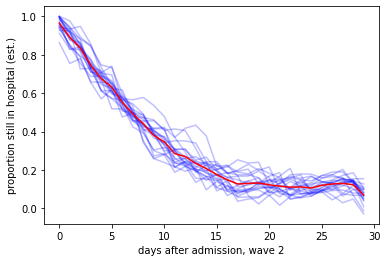

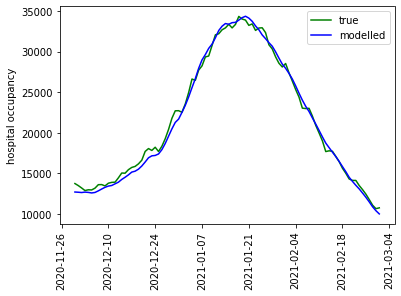

In [15]:
plt.clf()
x = list(range(len(pos)))
for y in admiss_occup_outputs:
    plt.plot(x, cumsumflip(y), color="blue", alpha=0.25)
y_avg_admiss_occup = []
for i in range(len(y)):
    y_avg_admiss_occup.append(np.mean(admiss_occup_outputs[:,i]))
plt.plot(x, cumsumflip(y_avg_admiss_occup), color="red", alpha=1)
plt.xlabel("days after admission, wave %d" % wave)
plt.ylabel("proportion still in hospital (est.)")
plt.savefig("admiss_occup_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

plt.clf()
true, pred = _g(np.array(y_avg_admiss_occup), admissions_stream, occupancy_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true, color="green", label="true")
plt.plot(x, pred, color="blue", label="modelled")
plt.ylabel("hospital occupancy")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(14))
plt.savefig("admiss_occup_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

admiss_occup[wave] = y_avg_admiss_occup

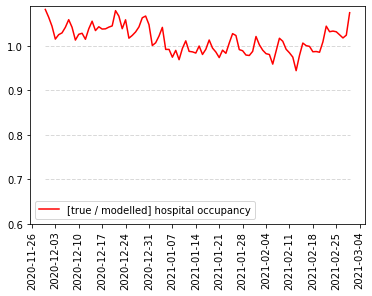

In [16]:
plt.clf()
true, pred = _g(y_avg_admiss_occup, admissions_stream, occupancy_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true/pred, color="red", label="[true / modelled] hospital occupancy")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.ylim(0.6,None)
y_locs,_ = plt.yticks()
plt.hlines(y_locs, x[0], x[-1], color="black", linestyles='dashed', alpha=0.15, linewidth=1)
plt.savefig("admiss_occup_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

2 0.9637981557229746 (9.167837728885157,)


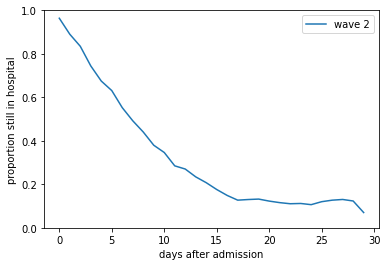

In [17]:
for wave,y_avg_admiss_occup in admiss_occup.items():
    print(wave, np.sum(y_avg_admiss_occup), center_of_mass(np.array(y_avg_admiss_occup)))
          
plt.clf()
x = range(n_dim)
for wave,y_avg_admiss_occup in admiss_occup.items():
    if wave==4:
        continue
    plt.plot(x, cumsumflip(y_avg_admiss_occup), label="wave %d" % wave)
plt.xlabel("days after admission")
plt.ylabel("proportion still in hospital")
plt.legend()
plt.savefig("admiss_occup_compare.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.ylim(0,1)
plt.show()
#print(list(zip(x,y_avg_admiss_occup)))